#**Neural Machine Translation with RNNs**
modify from CS224N: Natural Language Processing with Deep Learning
Stanford / Spring 2024 Assignment 3

---
In Machine Translation, our goal is to convert a sentence from the source language (e.g. Cherokee)to the target language (e.g. English). In this assignment, we will implement a sequence-to-sequence(Seq2Seq) network with attention, to build a Neural Machine Translation (NMT) system.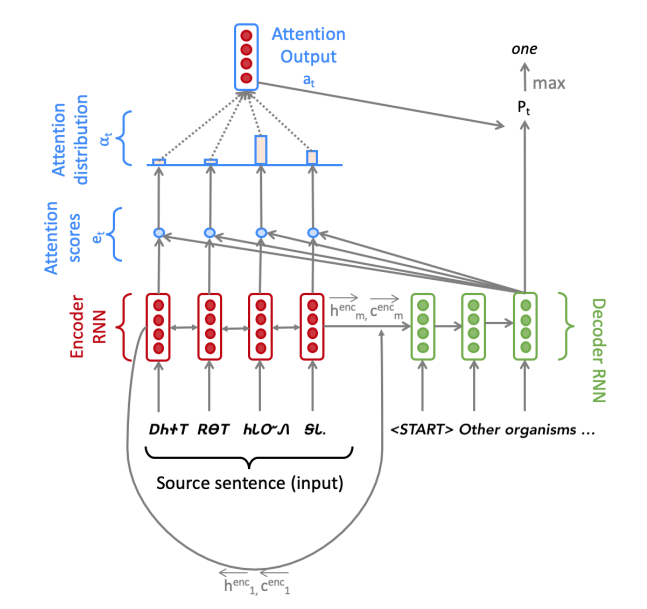

# **install package and download dataset**

In [15]:
# !wget https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1214/assignments/a4.zip
# !pip install sentencepiece
# !pip install sacrebleu
# !pip install nltk
# !unzip a4.zip

# **import package**

In [16]:
import math
from typing import List, Tuple, Dict, Set, Union
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import nltk
import sentencepiece as spm
from collections import Counter,namedtuple
from itertools import chain
import json
import sys
import pickle
import time
import sacrebleu
from tqdm import tqdm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/wsad1232885/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **TODO 1**
implement padding

In [17]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
        The paddings should be at the end of each sentence.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    ### YOUR CODE HERE (4-6 Lines)
    max_length = max([len(sublist) for sublist in sents])
    for sent in sents:
        diff = max_length - len(sent)
        sents_padded.append(sent + [pad_token] * diff)
    ### END YOUR CODE
    return sents_padded


def read_corpus(file_path, source, vocab_size=2500):
    """ Read file, where each sentence is dilineated by a `\n`.
    @param file_path (str): path to file containing corpus
    @param source (str): "tgt" or "src" indicating whether text
        is of the source language or target language
    @param vocab_size (int): number of unique subwords in
        vocabulary when reading and tokenizing
    """
    data = []
    sp = spm.SentencePieceProcessor()
    sp.load('{}.model'.format(source))

    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            subword_tokens = sp.encode_as_pieces(line)
            # only append <s> and </s> to the target sentence
            if source == 'tgt':
                subword_tokens = ['<s>'] + subword_tokens + ['</s>']
            data.append(subword_tokens)

    return data


def autograder_read_corpus(file_path, source):
    """ Read file, where each sentence is dilineated by a `\n`.
    @param file_path (str): path to file containing corpus
    @param source (str): "tgt" or "src" indicating whether text
        is of the source language or target language
    """
    data = []
    for line in open(file_path):
        sent = nltk.word_tokenize(line)
        # only append <s> and </s> to the target sentence
        if source == 'tgt':
            sent = ['<s>'] + sent + ['</s>']
        data.append(sent)

    return data


def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        src_sents = [e[0] for e in examples]
        tgt_sents = [e[1] for e in examples]

        yield src_sents, tgt_sents



# **Vocabulary setting**

In [18]:
class VocabEntry(object):
    """ Vocabulary Entry, i.e. structure containing either
    src or tgt language terms.
    """
    def __init__(self, word2id=None):
        """ Init VocabEntry Instance.
        @param word2id (dict): dictionary mapping words 2 indices
        """
        if word2id:
            self.word2id = word2id
        else:
            self.word2id = dict()
            self.word2id['<pad>'] = 0   # Pad Token
            self.word2id['<s>'] = 1 # Start Token
            self.word2id['</s>'] = 2    # End Token
            self.word2id['<unk>'] = 3   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        """ Retrieve word's index. Return the index for the unk
        token if the word is out of vocabulary.
        @param word (str): word to look up.
        @returns index (int): index of word
        """
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        """ Check if word is captured by VocabEntry.
        @param word (str): word to look up
        @returns contains (bool): whether word is contained
        """
        return word in self.word2id

    def __setitem__(self, key, value):
        """ Raise error, if one tries to edit the VocabEntry.
        """
        raise ValueError('vocabulary is readonly')

    def __len__(self):
        """ Compute number of words in VocabEntry.
        @returns len (int): number of words in VocabEntry
        """
        return len(self.word2id)

    def __repr__(self):
        """ Representation of VocabEntry to be used
        when printing the object.
        """
        return 'Vocabulary[size=%d]' % len(self)

    def id2word(self, wid):
        """ Return mapping of index to word.
        @param wid (int): word index
        @returns word (str): word corresponding to index
        """
        return self.id2word[wid]

    def add(self, word):
        """ Add word to VocabEntry, if it is previously unseen.
        @param word (str): word to add to VocabEntry
        @return index (int): index that the word has been assigned
        """
        if word not in self:
            wid = self.word2id[word] = len(self)
            self.id2word[wid] = word
            return wid
        else:
            return self[word]

    def words2indices(self, sents):
        """ Convert list of words or list of sentences of words
        into list or list of list of indices.
        @param sents (list[str] or list[list[str]]): sentence(s) in words
        @return word_ids (list[int] or list[list[int]]): sentence(s) in indices
        """
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        """ Convert list of indices into words.
        @param word_ids (list[int]): list of word ids
        @return sents (list[str]): list of words
        """
        return [self.id2word[w_id] for w_id in word_ids]

    def to_input_tensor(self, sents: List[List[str]], device: torch.device) -> torch.Tensor:
        """ Convert list of sentences (words) into tensor with necessary padding for
        shorter sentences.

        @param sents (List[List[str]]): list of sentences (words)
        @param device: device on which to load the tesnor, i.e. CPU or GPU

        @returns sents_var: tensor of (max_sentence_length, batch_size)
        """
        word_ids = self.words2indices(sents)
        sents_t = pad_sents(word_ids, self['<pad>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return torch.t(sents_var)

    @staticmethod
    def from_corpus(corpus, size, freq_cutoff=2):
        """ Given a corpus construct a Vocab Entry.
        @param corpus (list[str]): corpus of text produced by read_corpus function
        @param size (int): # of words in vocabulary
        @param freq_cutoff (int): if word occurs n < freq_cutoff times, drop the word
        @returns vocab_entry (VocabEntry): VocabEntry instance produced from provided corpus
        """
        vocab_entry = VocabEntry()
        word_freq = Counter(chain(*corpus))
        valid_words = [w for w, v in word_freq.items() if v >= freq_cutoff]
        print('number of word types: {}, number of word types w/ frequency >= {}: {}'
              .format(len(word_freq), freq_cutoff, len(valid_words)))
        top_k_words = sorted(valid_words, key=lambda w: word_freq[w], reverse=True)[:size]
        for word in top_k_words:
            vocab_entry.add(word)
        return vocab_entry

    @staticmethod
    def from_subword_list(subword_list):
        vocab_entry = VocabEntry()
        for subword in subword_list:
            vocab_entry.add(subword)
        return vocab_entry


class Vocab(object):
    """ Vocab encapsulating src and target langauges.
    """
    def __init__(self, src_vocab: VocabEntry, tgt_vocab: VocabEntry):
        """ Init Vocab.
        @param src_vocab (VocabEntry): VocabEntry for source language
        @param tgt_vocab (VocabEntry): VocabEntry for target language
        """
        self.src = src_vocab
        self.tgt = tgt_vocab

    @staticmethod
    def build(src_sents, tgt_sents) -> 'Vocab':
        """ Build Vocabulary.
        @param src_sents (list[str]): Source subwords provided by SentencePiece
        @param tgt_sents (list[str]): Target subwords provided by SentencePiece
        """

        print('initialize source vocabulary ..')
        src = VocabEntry.from_subword_list(src_sents)

        print('initialize target vocabulary ..')
        tgt = VocabEntry.from_subword_list(tgt_sents)

        return Vocab(src, tgt)

    def save(self, file_path):
        """ Save Vocab to file as JSON dump.
        @param file_path (str): file path to vocab file
        """
        with open(file_path, 'w') as f:
            json.dump(dict(src_word2id=self.src.word2id, tgt_word2id=self.tgt.word2id), f, indent=2)

    @staticmethod
    def load(file_path):
        """ Load vocabulary from JSON dump.
        @param file_path (str): file path to vocab file
        @returns Vocab object loaded from JSON dump
        """
        entry = json.load(open(file_path, 'r'))
        src_word2id = entry['src_word2id']
        tgt_word2id = entry['tgt_word2id']

        return Vocab(VocabEntry(src_word2id), VocabEntry(tgt_word2id))

    def __repr__(self):
        """ Representation of Vocab to be used
        when printing the object.
        """
        return 'Vocab(source %d words, target %d words)' % (len(self.src), len(self.tgt))


def get_vocab_list(file_path, source, vocab_size):
    """ Use SentencePiece to tokenize and acquire list of unique subwords.
    @param file_path (str): file path to corpus
    @param source (str): tgt or src
    @param vocab_size: desired vocabulary size
    """
    spm.SentencePieceTrainer.train(input=file_path, model_prefix=source, vocab_size=vocab_size)     # train the spm model
    sp = spm.SentencePieceProcessor()   # create an instance; this saves .model and .vocab files
    sp.load('{}.model'.format(source))    # loads tgt.model or src.model
    sp_list = [sp.id_to_piece(piece_id) for piece_id in range(sp.get_piece_size())]                 # this is the list of subwords
    return sp_list


generate vocabulary

In [19]:
src_sents = get_vocab_list("./a4/chr_en_data/train.chr", source='src', vocab_size=21000)
tgt_sents = get_vocab_list("./a4/chr_en_data/train.en", source='tgt', vocab_size=8000)
vocab = Vocab.build(src_sents, tgt_sents)
print('generated vocabulary, source %d words, target %d words' % (len(src_sents), len(tgt_sents)))
vocab.save("vocab.json")
print('vocabulary saved to %s' % "vocab.json")

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./a4/chr_en_data/train.chr
  input_format: 
  model_prefix: src
  model_type: UNIGRAM
  vocab_size: 21000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy:

['<unk>', '<s>', '</s>', ',', '.', '▁ᎠᎴ', '▁ᎾᏍᎩ', ';', 'Ꮓ', '▁ᎯᎠ', '▁ᎨᏒ', '▁', 'Ꭲ', '▁ᎥᏝ', '▁ᎨᏒᎢ', 'ᏰᏃ', 'Ꭹ', '▁ᎨᏎᏍᏗ', '▁ᎤᏁᎳᏅᎯ', '▁ᏃᎴ', '▁Ꭴ', '?', '▁Ꭰ', '▁ᏴᏫ', 'Ꮙ', 'Ꮧ', 'Ꭿ', '▁ᎩᎶ', '▁ᎾᏍᏉ', '▁ᎢᏳᏍᏗ', '▁ᎾᎿ', '▁ᎾᏍᎩᏯ', '\u2060', '▁ᎠᏎᏃ', '▁ᎠᏴ', 'Ꭽ', '▁Ꮎ', '▁ᏱᎩ', '-', '▁ᏥᎩ', '▁ᏱᎰᏩ', '▁ᎪᎱᏍᏗ', '▁ᏂᎦᏛ', '▁ᏂᎯ', '▁ᎢᎦ', '▁ᎤᎬᏫᏳᎯ', '▁ᏥᏌ', '▁ᏂᎨᏒᎾ', 'Ᏹ', '▁“', 'Ꮎ', 'ᏍᎩᏂ', 'Ꮫ', '▁ᎣᏍᏛ', '▁ᎯᎠᏃ', 'ᏍᏗ', '▁ᎤᏪᏥ', '▁Ꮷ', '▁Ꮧ', '▁ᎢᏳᏃ', '▁ᎾᏍᎩᏃ', '▁ᏧᏪᏥ', '▁ᎦᎶᏁᏛ', 'Ꮣ', '▁ᏄᏪᏎᎢ', '▁ᎿᏉ', '▁ᎠᏂ', '▁ᎡᎶᎯ', '▁ᏞᏍᏗ', '▁Ꮵ', '▁ᎨᏍᏗ', '▁ᎿᏉᏃ', '▁ᎤᏲ', 'Ꭶ', '▁ᎤᏛᏁ', '▁Ꮳ', '▁ᎤᏣᏘ', '▁ᎠᏥᎸ', '▁”', '▁Ᏹ', '▁Ꮪ', '▁ᏫᎵᎻ', ',”', '▁ᎾᎯᏳ', '▁ᏂᎦᎥ', '▁ᎬᏂᎨᏒ', 'Ꮒ', '▁ᎠᏍᎦᏯ', '▁ᎦᎸᏉᏗᏳ', '▁ᎬᏂᏳᏉ', '▁ᏄᏍᏛ', 'Ꮕ', '▁ᎦᏙ', '▁ᎧᏃᎮᏛ', '▁ᎡᎯ', '▁ᎤᏩᏒ', '▁ᎠᏁᎯ', '▁ᎦᎸᎳᏗ', '▁ᎠᏰᎵ', '▁ᎠᏕᎸ', '▁ᎨᏎᎢ', '▁ᎤᏤᎵ', '▁ᏰᎵ', '▁ᏌᏉ', '▁ᎤᏤᎵᎦ', 'Ꭸ', '▁ᎠᎹ', 'Ꮟ', '▁ᎢᏣ', '▁ᎤᏂ', 'Ꮅ', '▁ᎢᏴᏛ', 'Ꮈ', 'ᏗᏱ', '▁Ꭲ', '▁ᎾᏂᎥ', '▁ᎣᏏᏳ', '▁ᎠᏎ', 'Ᏻ', '▁ᎦᏙᎯ', '▁ᏔᎵ', 'Ꮄ', '▁ᎢᏏᎵ', '▁[', '▁ᎤᏟ', '▁ᎪᎯ', '▁ᏗᎧᎿᏩᏛᏍᏗ', '▁Ꭿ', '▁ᎠᏓᏅᏙ', '▁Ꮣ', '▁ᎣᏍᏓ', 'Ꮢ', '▁ᎠᏂᏍᎦᏯ', '▁ᎨᏎ', '▁ᎢᏥᏈᏱ', '.”', '▁ᏔᎵᏁ', '▁ᎼᏏ', '▁Ꭶ', 'Ꮂ', 'ᏍᎪ', 

cc(618) LOG(INFO) EM sub_iter=1 size=8785 obj=7.76295 num_tokens=47534 num_tokens/piece=5.41081
trainer_interface.cc(687) LOG(INFO) Saving model: tgt.model
trainer_interface.cc(699) LOG(INFO) Saving vocabs: tgt.vocab


# **TODO 2**

implement model embedding

In [20]:
class ModelEmbeddings(nn.Module):
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']
        
        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.source=nn.Embedding(len(vocab.src), embed_size, padding_idx=src_pad_token_idx)
        self.target=nn.Embedding(len(vocab.tgt), embed_size, padding_idx=tgt_pad_token_idx)


        ### END YOUR CODE
    def forward(self,x,src=True):
        if src:
            x=self.source(x)
        else:
            x=self.target(x)
        return x


# **Model description (training procedure)**
Given a sentence in the source language, we look up the subword embeddings from an embeddings matrix, yielding
$x_1,...,x_m(xᵢ∈\mathbb{R}^{e × 1}$),where m is the length of the source sentence and e is the embedding size.


We feed these embeddings to the bidirectional encoder, yielding hidden states and cell states for both the forwards (→) and backwards (←) LSTMs. The forwards and backwards versions are concatenated to give

**hidden states
$h^{enc}_i$
and cell states
$c^{enc}_i$**

  $h^{enc}_i=[\overleftarrow{h^{enc}_i};\overrightarrow{h^{enc}_i}] \ where \ h^{enc}_i \in \mathbb{R}^{2h × 1} ,\ \overleftarrow{h^{enc}_i},\overrightarrow{h^{enc}_i} \in \mathbb{R}^{h × 1}$

  $c^{enc}_i=[\overleftarrow{c^{enc}_i};\overrightarrow{c^{enc}_i}] \ where \ c^{enc}_i \in \mathbb{R}^{2h × 1} ,\ \overleftarrow{c^{enc}_i},\overrightarrow{c^{enc}_i} \in \mathbb{R}^{h × 1}$

We then initialize the decoder’s first hidden state $h^{dec}_0$ and cell state
 $c^{dec}_0$ with a linear projection of the encoder’s final hidden state and final cell state

$h^{dec}_0=W_h[\overleftarrow{h^{enc}_1};\overrightarrow{h^{enc}_m}] \ where \ h^{dec}_0 \in \mathbb{R}^{h × 1} ,\ W_h \in \mathbb{R}^{h × 2h}$

$c^{dec}_0=W_c[\overleftarrow{c^{enc}_1};\overrightarrow{c^{enc}_m}] \ where \ c^{dec}_0 \in \mathbb{R}^{h × 1} ,\ W_c \in \mathbb{R}^{h × 2h}$

With the decoder initialized, we must now feed it a target sentence. On the $t^{th}$ step, we look up the
embedding for the $t^{th}$ subword, $ y_t ∈\mathbb{R}^{e × 1}$.We then concatenate $y_t$ with the combined-output vector
$o_{t−1} \in \mathbb{R}^{h × 1} $ from the previous timestep to produce
$y_t \in \mathbb{R}^{(e+h) × 1} $

. Note that for the first target subword (i.e. the start token) o0 is a zero-vector. We then
feed yt as input to the decoder.

$h^{dec}_t,c^{dec}_t=Decoder(\overline{y_t},h^{dec}_{t-1},c^{dec}_{t-1}) \ where \ h^{dec}_t \in \mathbb{R}^{h × 1}, \ c^{dec}_t \in \mathbb{R}^{h × 1}$


We then use $h^{dec}_t$ to compute multiplicative attention over $h^{enc}_1 ,...,h^{enc}_m$ :

$e_{t,i}=(h^{dec}_t)^TW_{attProj}h^{enc}_i \ where \ e_t \in \mathbb{R}^{m × 1},W_{attProj} \in \ \mathbb{R}^{h × 2h} \quad 1 \le i \le m$

$\alpha_t=softmax(e_t) \ where \ \alpha_t \in \mathbb{R}^{m × 1} $

$a_t= \sum_{i=1}^m \alpha_th^{enc}_i \ where \ a_t \in \mathbb{R}^{2h × 1}$

We now concatenate the attention output at with the decoder hidden state $h^{dec}_t$ and pass this through a linear layer, tanh, and dropout to attain the combined-output vector $o_t$.

$u_t=[a_t;h^{dec}_t] \ where \ u_t \in \mathbb{R}^{3h × 1}$

$v_t=W_uu_t \ where \ v_t \in \mathbb{R}^{h × 1}, W_u \in \mathbb{R}^{h × 3h}$

$o_t=dropout(tanh(v_t)) \ where \ o_t \in \mathbb{R}^{h × 1}$

Then, we produce a probability distribution $P_t$ over target subwords at the $t_{th}$ timestep:
$P_t=softmax(W_{vocab}o_t) \ where  P_t \in \mathbb{R}^{V_t × 1} \ W_{vocab} \in \mathbb{R}^{V_t × h}$

Here, $V_t$ is the size of the target vocabulary. Finally, to train the network we then compute the softmax cross entropy loss between $P_t$ and $g_t$, where gt is the one-hot vector of the target subword at timestep t:

$J_t(θ)=CrossEntropy(P_t,g_t)$

Here, $Θ$ represents all the parameters of the model and $J_t(θ)$ is the loss on step t of the decoder. Now that we have described the model, let’s try implementing it for Cherokee to English translation!

#TODO 3 ,4 ,5
implement NMT model


each TODO have a validation below respectively

In [21]:
Hypothesis = namedtuple('Hypothesis', ['value', 'score'])
class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size, the size of hidden states (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None
        # For sanity check only, not relevant to implementation
        self.gen_sanity_check = False
        self.counter = 0




        ### YOUR CODE HERE (~8 Lines)
        ### TODO - Initialize the following variables:
        ###     self.encoder = nn.LSTM() (Bidirectional LSTM with bias)
        ###     self.decoder = nn.LSTMCell() (LSTM Cell with bias)
        ###     self.h_projection = nn.Linear() (Linear Layer with no bias), called W_{h}.
        ###     self.c_projection = nn.Linear() (Linear Layer with no bias), called W_{c}.
        ###     self.att_projection = nn.Linear() (Linear Layer with no bias), called W_{attProj}.
        ###     self.combined_output_projection = nn.Linear() (Linear Layer with no bias), called W_{u}.
        ###     self.target_vocab_projection = nn.Linear() (Linear Layer with no bias), called W_{vocab}.
        ###     self.dropout = nn.Dropout() (Dropout Layer)
        ###
        ### Use the following docs to properly initialize these variables:
        ###     LSTM:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        ###     LSTM Cell:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
        ###     Linear Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout




        ### END YOUR CODE


    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the NMT system.

        @param source (List[List[str]]): list of source sentence tokens
        @param target (List[List[str]]): list of target sentence tokens, wrapped by `<s>` and `</s>`

        @returns scores (Tensor): a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        """
        # Compute sentence lengths
        source_lengths = [len(s) for s in source]

        #list[list[str]]
        # Convert list of lists into tensors
        source_padded = self.vocab.src.to_input_tensor(source, device=self.device)   # Tensor: (src_len, b)
        target_padded = self.vocab.tgt.to_input_tensor(target, device=self.device)   # Tensor: (tgt_len, b)

        ###     Run the network forward:
        ###     1. Apply the encoder to `source_padded` by calling `self.encode()`
        ###     2. Generate sentence masks for `source_padded` by calling `self.generate_sent_masks()`
        ###     3. Apply the decoder to compute combined-output by calling `self.decode()`
        ###     4. Compute log probability distribution over the target vocabulary using the
        ###        combined_outputs returned by the `self.decode()` function.

        enc_hiddens, dec_init_state = self.encode(source_padded, source_lengths)
        enc_masks = self.generate_sent_masks(enc_hiddens, source_lengths)
        combined_outputs = self.decode(enc_hiddens, enc_masks, dec_init_state, target_padded)
        P = F.log_softmax(self.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.vocab.tgt['<pad>']).float()

        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[1:].unsqueeze(-1), dim=-1).squeeze(-1) * target_masks[1:]
        scores = target_gold_words_log_prob.sum(dim=0)
        return scores


    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """ Apply the encoder to source sentences to obtain encoder hidden states.
            Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

        @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                        b = batch_size, src_len = maximum source sentence length. Note that
                                       these have already been sorted in order of longest to shortest sentence.
        @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
        @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                        b = batch size, src_len = maximum source sentence length, h = hidden size.
        @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                                hidden state and cell.
        """


        enc_hiddens, dec_init_state = None, None








        ### YOUR CODE HERE (8~10 Lines)
        ### TODO:
        ###     1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
        ###         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
        ###         that there is no initial hidden state or cell for the decoder.
        ###     2. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
        ###         - Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.
        ###         - After you apply the encoder, you need to apply the `pad_packed_sequence` function to enc_hiddens.
        ###         - Note that the shape of the tensor returned by the encoder is (src_len, b, h*2) and we want to
        ###           return a tensor of shape (b, src_len, h*2) as `enc_hiddens`.
        ###     3. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
        ###         - `init_decoder_hidden`:
        ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
        ###             This is h_0^{dec}. Here b = batch size, h = hidden size
        ###         - `init_decoder_cell`:
        ###             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the c_projection layer to this in order to compute init_decoder_cell.
        ###             This is c_0^{dec}. Here b = batch size, h = hidden size
        ###
        ### See the following docs, as you may need to use some of the following functions in your implementation:
        ###     Pack the padded sequence X before passing to the encoder:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
        ###     Pad the packed sequence, enc_hiddens, returned by the encoder:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_packed_sequence
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat
        ###     Tensor Permute:
        ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute





        ### END YOUR CODE

        return enc_hiddens, dec_init_state


    def decode(self, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
                dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
        """Compute combined output vectors for a batch.

        @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                     b = batch size, src_len = maximum source sentence length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                     b = batch size, src_len = maximum source sentence length.
        @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
        @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                       tgt_len = maximum target sentence length, b = batch size.

        @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                        tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
        """
        # Chop of the <END> token for max length sentences.
        target_padded = target_padded[:-1]

        # Initialize the decoder state (hidden and cell)
        dec_state = dec_init_state

        # Initialize previous combined output vector o_{t-1} as zero
        batch_size = enc_hiddens.size(0)
        o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

        # Initialize a list we will use to collect the combined output o_t on each step
        combined_outputs = []





        ### YOUR CODE HERE (~9 Lines)
        ### TODO:
        ###     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
        ###         which should be shape (b, src_len, h),
        ###         where b = batch size, src_len = maximum source length, h = hidden size.
        ###         This is applying W_{attProj} to h^enc.
        ###     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
        ###         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.
        ###     3. Use the torch.split function to iterate over the time dimension of Y.
        ###         Within the for loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
        ###             - Squeeze Y_t into a tensor of dimension (b, e).
        ###             - Construct Ybar_t by concatenating Y_t with o_prev on their last dimension
        ###             - Use the step function to compute the the Decoder's next (cell, state) values
        ###               as well as the new combined output o_t.
        ###             - Append o_t to combined_outputs
        ###             - Update o_prev to the new o_t.
        ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
        ###         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
        ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
        ###
        ### Note:
        ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
        ###      over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
        ###
        ### You may find some of these functions useful:
        ###     Zeros Tensor:
        ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
        ###     Tensor Splitting (iteration):
        ###         https://pytorch.org/docs/stable/torch.html#torch.split
        ###     Tensor Dimension Squeezing:
        ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat
        ###     Tensor Stacking:
        ###         https://pytorch.org/docs/stable/torch.html#torch.stack






        ### END YOUR CODE

        return combined_outputs


    def step(self, Ybar_t: torch.Tensor,
            dec_state: Tuple[torch.Tensor, torch.Tensor],
            enc_hiddens: torch.Tensor,
            enc_hiddens_proj: torch.Tensor,
            enc_masks: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        """ Compute one forward step of the LSTM decoder, including the attention computation.

        @param Ybar_t (Tensor): Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                                where b = batch size, e = embedding size, h = hidden size.
        @param dec_state (tuple(Tensor, Tensor)): Tuple of tensors both with shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's prev hidden state, second tensor is decoder's prev cell.
        @param enc_hiddens (Tensor): Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                    src_len = maximum source length, h = hidden size.
        @param enc_hiddens_proj (Tensor): Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                    where b = batch size, src_len = maximum source length, h = hidden size.
        @param enc_masks (Tensor): Tensor of sentence masks shape (b, src_len),
                                    where b = batch size, src_len is maximum source length.

        @returns dec_state (tuple (Tensor, Tensor)): Tuple of tensors both shape (b, h), where b = batch size, h = hidden size.
                First tensor is decoder's new hidden state, second tensor is decoder's new cell.
        @returns combined_output (Tensor): Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
        @returns e_t (Tensor): Tensor of shape (b, src_len). It is attention scores distribution.
                                Note: You will not use this outside of this function.
                                      We are simply returning this value so that we can sanity check
                                      your implementation.
        """

        combined_output = None



        ### YOUR CODE HERE (~3 Lines)
        ### TODO:
        ###     1. Apply the decoder to `Ybar_t` and `dec_state`to obtain the new dec_state.
        ###     2. Split dec_state into its two parts (dec_hidden, dec_cell)
        ###     3. Compute the attention scores e_t, a Tensor shape (b, src_len).
        ###        Note: b = batch_size, src_len = maximum source length, h = hidden size.
        ###
        ###       Hints:
        ###         - dec_hidden is shape (b, h) and corresponds to h^dec_t
        ###         - enc_hiddens_proj is shape (b, src_len, h) and corresponds to W_{attProj} h^enc (batched).
        ###         - Use batched matrix multiplication (torch.bmm) to compute e_t (be careful about the input/ output shapes!)
        ###         - To get the tensors into the right shapes for bmm, you will need to do some squeezing and unsqueezing.
        ###         - When using the squeeze() function make sure to specify the dimension you want to squeeze
        ###             over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
        ###
        ### Use the following docs to implement this functionality:
        ###     Batch Multiplication:
        ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
        ###     Tensor Unsqueeze:
        ###         https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
        ###     Tensor Squeeze:
        ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze




        ### END YOUR CODE

        # Set e_t to -inf where enc_masks has 1
        if enc_masks is not None:
            e_t.data.masked_fill_(enc_masks.bool(), -float('inf'))




        ### YOUR CODE HERE (~6 Lines)
        ### TODO:
        ###     1. Apply softmax to e_t to yield alpha_t
        ###     2. Use batched matrix multiplication between alpha_t and enc_hiddens to obtain the
        ###         attention output vector, a_t.
        #$$     Hints:
        ###           - alpha_t is shape (b, src_len)
        ###           - enc_hiddens is shape (b, src_len, 2h)
        ###           - a_t should be shape (b, 2h)
        ###           - You will need to do some squeezing and unsqueezing.
        ###     Note: b = batch size, src_len = maximum source length, h = hidden size.
        ###
        ###     3. Concatenate dec_hidden with a_t to compute tensor U_t
        ###     4. Apply the combined output projection layer to U_t to compute tensor V_t
        ###     5. Compute tensor O_t by first applying the Tanh function and then the dropout layer.
        ###
        ### Use the following docs to implement this functionality:
        ###     Softmax:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.functional.softmax
        ###     Batch Multiplication:
        ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
        ###     Tensor View:
        ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat
        ###     Tanh:
        ###         https://pytorch.org/docs/stable/torch.html#torch.tanh





        ### END YOUR CODE

        combined_output = O_t
        return dec_state, combined_output, e_t

    def generate_sent_masks(self, enc_hiddens: torch.Tensor, source_lengths: List[int]) -> torch.Tensor:
        """ Generate sentence masks for encoder hidden states.

        @param enc_hiddens (Tensor): encodings of shape (b, src_len, 2*h), where b = batch size,
                                     src_len = max source length, h = hidden size.
        @param source_lengths (List[int]): List of actual lengths for each of the sentences in the batch.

        @returns enc_masks (Tensor): Tensor of sentence masks of shape (b, src_len),
                                    where src_len = max source length, h = hidden size.
        """
        enc_masks = torch.zeros(enc_hiddens.size(0), enc_hiddens.size(1), dtype=torch.float)
        for e_id, src_len in enumerate(source_lengths):
            enc_masks[e_id, src_len:] = 1
        return enc_masks.to(self.device)


    def beam_search(self, src_sent: List[str], beam_size: int=5, max_decoding_time_step: int=70) -> List[Hypothesis]:
        """ Given a single source sentence, perform beam search, yielding translations in the target language.
        @param src_sent (List[str]): a single source sentence (words)
        @param beam_size (int): beam size
        @param max_decoding_time_step (int): maximum number of time steps to unroll the decoding RNN
        @returns hypotheses (List[Hypothesis]): a list of hypothesis, each hypothesis has two fields:
                value: List[str]: the decoded target sentence, represented as a list of words
                score: float: the log-likelihood of the target sentence
        """
        src_sents_var = self.vocab.src.to_input_tensor([src_sent], self.device)

        src_encodings, dec_init_vec = self.encode(src_sents_var, [len(src_sent)])
        src_encodings_att_linear = self.att_projection(src_encodings)

        h_tm1 = dec_init_vec
        att_tm1 = torch.zeros(1, self.hidden_size, device=self.device)

        eos_id = self.vocab.tgt['</s>']

        hypotheses = [['<s>']]
        hyp_scores = torch.zeros(len(hypotheses), dtype=torch.float, device=self.device)
        completed_hypotheses = []

        t = 0
        while len(completed_hypotheses) < beam_size and t < max_decoding_time_step:
            t += 1
            hyp_num = len(hypotheses)

            exp_src_encodings = src_encodings.expand(hyp_num,
                                                     src_encodings.size(1),
                                                     src_encodings.size(2))

            exp_src_encodings_att_linear = src_encodings_att_linear.expand(hyp_num,
                                                                           src_encodings_att_linear.size(1),
                                                                           src_encodings_att_linear.size(2))

            y_tm1 = torch.tensor([self.vocab.tgt[hyp[-1]] for hyp in hypotheses], dtype=torch.long, device=self.device)
            y_t_embed = self.model_embeddings.target(y_tm1)

            x = torch.cat([y_t_embed, att_tm1], dim=-1)

            (h_t, cell_t), att_t, _  = self.step(x, h_tm1,
                                                      exp_src_encodings, exp_src_encodings_att_linear, enc_masks=None)

            # log probabilities over target words
            log_p_t = F.log_softmax(self.target_vocab_projection(att_t), dim=-1)

            live_hyp_num = beam_size - len(completed_hypotheses)
            contiuating_hyp_scores = (hyp_scores.unsqueeze(1).expand_as(log_p_t) + log_p_t).view(-1)
            top_cand_hyp_scores, top_cand_hyp_pos = torch.topk(contiuating_hyp_scores, k=live_hyp_num)
            prev_hyp_ids = top_cand_hyp_pos // len(self.vocab.tgt)
            hyp_word_ids = top_cand_hyp_pos % len(self.vocab.tgt)
            new_hypotheses = []
            live_hyp_ids = []
            new_hyp_scores = []
            for prev_hyp_id, hyp_word_id, cand_new_hyp_score in zip(prev_hyp_ids, hyp_word_ids, top_cand_hyp_scores):
                prev_hyp_id = prev_hyp_id.item()
                hyp_word_id = hyp_word_id.item()
                cand_new_hyp_score = cand_new_hyp_score.item()
                hyp_word = self.vocab.tgt.id2word[hyp_word_id]
                new_hyp_sent = hypotheses[prev_hyp_id] + [hyp_word]
                if hyp_word == '</s>':
                    completed_hypotheses.append(Hypothesis(value=new_hyp_sent[1:-1],
                                                           score=cand_new_hyp_score))
                else:
                    new_hypotheses.append(new_hyp_sent)
                    live_hyp_ids.append(prev_hyp_id)
                    new_hyp_scores.append(cand_new_hyp_score)
            if len(completed_hypotheses) == beam_size:
                break

            live_hyp_ids = torch.tensor(live_hyp_ids, dtype=torch.long, device=self.device)
            h_tm1 = (h_t[live_hyp_ids], cell_t[live_hyp_ids])
            att_tm1 = att_t[live_hyp_ids]
            hypotheses = new_hypotheses
            hyp_scores = torch.tensor(new_hyp_scores, dtype=torch.float, device=self.device)
        if len(completed_hypotheses) == 0:
            completed_hypotheses.append(Hypothesis(value=hypotheses[0][1:],
                                                score=hyp_scores[0].item()))
        completed_hypotheses.sort(key=lambda hyp: hyp.score, reverse=True)

        return completed_hypotheses

    @property
    def device(self) -> torch.device:
        """ Determine which device to place the Tensors upon, CPU or GPU.
        """
        return self.model_embeddings.source.weight.device

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = NMT(vocab=params['vocab'], **args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.model_embeddings.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate),
            'vocab': self.vocab,
            'state_dict': self.state_dict()
        }

        torch.save(params, path)


#validation setting

In [22]:
def reinitialize_layers(model):
    """ Reinitialize the Layer Weights for Sanity Checks.
    """
    def init_weights(m):
        if type(m) == nn.Linear:
            m.weight.data.fill_(0.3)
            if m.bias is not None:
                m.bias.data.fill_(0.1)
        elif type(m) == nn.Embedding:
            m.weight.data.fill_(0.15)
        elif type(m) == nn.Dropout:
            nn.Dropout(DROPOUT_RATE)
    with torch.no_grad():
        model.apply(init_weights)


def generate_outputs(model, source, target, vocab):
    """ Generate outputs.
    """
    print ("-"*80)
    print("Generating Comparison Outputs")
    reinitialize_layers(model)
    model.gen_sanity_check = True
    model.counter = 0

    # Compute sentence lengths
    source_lengths = [len(s) for s in source]

    # Convert list of lists into tensors
    source_padded = model.vocab.src.to_input_tensor(source, device=model.device)
    target_padded = model.vocab.tgt.to_input_tensor(target, device=model.device)

    # Run the model forward
    with torch.no_grad():
        enc_hiddens, dec_init_state = model.encode(source_padded, source_lengths)
        enc_masks = model.generate_sent_masks(enc_hiddens, source_lengths)
        combined_outputs = model.decode(enc_hiddens, enc_masks, dec_init_state, target_padded)

    # Save Tensors to disk
    torch.save(enc_hiddens, './a4/sanity_check_en_es_data/enc_hiddens.pkl')
    torch.save(dec_init_state, './a4/sanity_check_en_es_data/dec_init_state.pkl')
    torch.save(enc_masks, './a4/sanity_check_en_es_data/enc_masks.pkl')
    torch.save(combined_outputs, './a4/sanity_check_en_es_data/combined_outputs.pkl')
    torch.save(target_padded, './a4/sanity_check_en_es_data/target_padded.pkl')

    # 1f
    # Inputs
    Ybar_t = torch.load('./a4/sanity_check_en_es_data/Ybar_t.pkl',)
    enc_hiddens_proj = torch.load('./a4/sanity_check_en_es_data/enc_hiddens_proj.pkl')
    reinitialize_layers(model)
    # Run Tests
    with torch.no_grad():
        dec_state_target, o_t_target, e_t_target = model.step(Ybar_t, dec_init_state, enc_hiddens, enc_hiddens_proj,
                                                        enc_masks)
    torch.save(dec_state_target, './a4/sanity_check_en_es_data/dec_state.pkl')
    torch.save(o_t_target, './a4/sanity_check_en_es_data/o_t.pkl')
    torch.save(e_t_target, './a4/sanity_check_en_es_data/e_t.pkl')

    model.gen_sanity_check = False

def stepFunction(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj, enc_masks):
       dec_state = torch.load('./a4/sanity_check_en_es_data/step_dec_state_{}.pkl'.format(COUNTER[0]),weights_only=True)
       o_t = torch.load('./a4/sanity_check_en_es_data/step_o_t_{}.pkl'.format(COUNTER[0]),weights_only=True)
       COUNTER[0]+=1
       return dec_state, o_t, None
def question_1d_sanity_check(model, src_sents, tgt_sents, vocab):
    """ Sanity check for question 1d.
        Compares student output to that of model with dummy data.
    """
    print("Running Sanity Check for Question 1d: Encode")
    print ("-"*80)

    # Configure for Testing
    reinitialize_layers(model)
    source_lengths = [len(s) for s in src_sents]
    source_padded = model.vocab.src.to_input_tensor(src_sents, device=model.device)

    # Load Outputs
    enc_hiddens_target = torch.load('./a4/sanity_check_en_es_data/enc_hiddens.pkl',weights_only=True)
    dec_init_state_target = torch.load('./a4/sanity_check_en_es_data/dec_init_state.pkl',weights_only=True)

    # Test
    with torch.no_grad():
        enc_hiddens_pred, dec_init_state_pred = model.encode(source_padded, source_lengths)
    assert(enc_hiddens_target.shape == enc_hiddens_pred.shape), "enc_hiddens shape is incorrect: it should be:\n {} but is:\n{}".format(enc_hiddens_target.shape, enc_hiddens_pred.shape)
    assert(np.allclose(enc_hiddens_target.numpy(), enc_hiddens_pred.numpy())), "enc_hiddens is incorrect: it should be:\n {} but is:\n{}".format(enc_hiddens_target, enc_hiddens_pred)
    print("enc_hiddens Sanity Checks Passed!")
    assert(dec_init_state_target[0].shape == dec_init_state_pred[0].shape), "dec_init_state[0] shape is incorrect: it should be:\n {} but is:\n{}".format(dec_init_state_target[0].shape, dec_init_state_pred[0].shape)
    assert(np.allclose(dec_init_state_target[0].numpy(), dec_init_state_pred[0].numpy())), "dec_init_state[0] is incorrect: it should be:\n {} but is:\n{}".format(dec_init_state_target[0], dec_init_state_pred[0])
    print("dec_init_state[0] Sanity Checks Passed!")
    assert(dec_init_state_target[1].shape == dec_init_state_pred[1].shape), "dec_init_state[1] shape is incorrect: it should be:\n {} but is:\n{}".format(dec_init_state_target[1].shape, dec_init_state_pred[1].shape)
    assert(np.allclose(dec_init_state_target[1].numpy(), dec_init_state_pred[1].numpy())), "dec_init_state[1] is incorrect: it should be:\n {} but is:\n{}".format(dec_init_state_target[1], dec_init_state_pred[1])
    print("dec_init_state[1] Sanity Checks Passed!")
    print ("-"*80)
    print("All Sanity Checks Passed for Question 1d: Encode!")
    print ("-"*80)


def question_1e_sanity_check(model, src_sents, tgt_sents, vocab):
    """ Sanity check for question 1e.
        Compares student output to that of model with dummy data.
    """
    print ("-"*80)
    print("Running Sanity Check for Question 1e: Decode")
    print ("-"*80)

    # Load Inputs
    dec_init_state = torch.load('./a4/sanity_check_en_es_data/dec_init_state.pkl',weights_only=True)
    enc_hiddens = torch.load('./a4/sanity_check_en_es_data/enc_hiddens.pkl',weights_only=True)
    enc_masks = torch.load('./a4/sanity_check_en_es_data/enc_masks.pkl',weights_only=True)
    target_padded = torch.load('./a4/sanity_check_en_es_data/target_padded.pkl',weights_only=True)

    # Load Outputs
    combined_outputs_target = torch.load('./a4/sanity_check_en_es_data/combined_outputs.pkl',weights_only=True)
    print(combined_outputs_target.shape)

    # Configure for Testing
    reinitialize_layers(model)
    COUNTER = [0]
    def stepFunction(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj, enc_masks):
       dec_state = torch.load('./a4/sanity_check_en_es_data/step_dec_state_{}.pkl'.format(COUNTER[0]),weights_only=True)
       o_t = torch.load('./a4/sanity_check_en_es_data/step_o_t_{}.pkl'.format(COUNTER[0]),weights_only=True)
       COUNTER[0]+=1
       return dec_state, o_t, None
    model.step = stepFunction

    # Run Tests
    with torch.no_grad():
        combined_outputs_pred = model.decode(enc_hiddens, enc_masks, dec_init_state, target_padded)
    assert(combined_outputs_target.shape == combined_outputs_pred.shape), "combined_outputs shape is incorrect: it should be:\n {} but is:\n{}".format(combined_outputs_target.shape, combined_outputs_pred.shape)
    assert(np.allclose(combined_outputs_pred.numpy(), combined_outputs_target.numpy())), "combined_outputs is incorrect: it should be:\n {} but is:\n{}".format(combined_outputs_target, combined_outputs_pred)
    print("combined_outputs Sanity Checks Passed!")
    print ("-"*80)
    print("All Sanity Checks Passed for Question 1e: Decode!")
    print ("-"*80)

def question_1f_sanity_check(model, src_sents, tgt_sents, vocab):
    """ Sanity check for question 1f.
        Compares student output to that of model with dummy data.
    """
    print ("-"*80)
    print("Running Sanity Check for Question 1f: Step")
    print ("-"*80)
    reinitialize_layers(model)

    # Inputs
    Ybar_t = torch.load('./a4/sanity_check_en_es_data/Ybar_t.pkl',weights_only=True)
    dec_init_state = torch.load('./a4/sanity_check_en_es_data/dec_init_state.pkl',weights_only=True)
    enc_hiddens = torch.load('./a4/sanity_check_en_es_data/enc_hiddens.pkl',weights_only=True)
    enc_masks = torch.load('./a4/sanity_check_en_es_data/enc_masks.pkl',weights_only=True)
    enc_hiddens_proj = torch.load('./a4/sanity_check_en_es_data/enc_hiddens_proj.pkl',weights_only=True)

    # Output
    dec_state_target = torch.load('./a4/sanity_check_en_es_data/dec_state.pkl',weights_only=True)
    o_t_target = torch.load('./a4/sanity_check_en_es_data/o_t.pkl',weights_only=True)
    e_t_target = torch.load('./a4/sanity_check_en_es_data/e_t.pkl',weights_only=True)
    # Run Tests
    with torch.no_grad():
        dec_state_pred, o_t_pred, e_t_pred= model.step(Ybar_t, dec_init_state, enc_hiddens, enc_hiddens_proj, enc_masks)
    assert(dec_state_target[0].shape == dec_state_pred[0].shape), "decoder_state[0] shape is incorrect: it should be:\n {} but is:\n{}".format(dec_state_target[0].shape, dec_state_pred[0].shape)
    assert(np.allclose(dec_state_target[0].numpy(), dec_state_pred[0].numpy())), "decoder_state[0] is incorrect: it should be:\n {} but is:\n{}".format(dec_state_target[0], dec_state_pred[0])
    print("dec_state[0] Sanity Checks Passed!")
    assert(dec_state_target[1].shape == dec_state_pred[1].shape), "decoder_state[1] shape is incorrect: it should be:\n {} but is:\n{}".format(dec_state_target[1].shape, dec_state_pred[1].shape)
    assert(np.allclose(dec_state_target[1].numpy(), dec_state_pred[1].numpy())), "decoder_state[1] is incorrect: it should be:\n {} but is:\n{}".format(dec_state_target[1], dec_state_pred[1])
    print("dec_state[1] Sanity Checks Passed!")
    assert(np.allclose(o_t_target.numpy(), o_t_pred.numpy())), "combined_output is incorrect: it should be:\n {} but is:\n{}".format(o_t_target, o_t_pred)
    print("combined_output  Sanity Checks Passed!")
    assert(np.allclose(e_t_target.numpy(), e_t_pred.numpy())), "e_t is incorrect: it should be:\n {} but is:\n{}".format(e_t_target, e_t_pred)
    print("e_t Sanity Checks Passed!")
    print ("-"*80)
    print("All Sanity Checks Passed for Question 1f: Step!")
    print ("-"*80)


def sanity_read_corpus(file_path, source):
    """ Read file, where each sentence is dilineated by a `\n`.
    @param file_path (str): path to file containing corpus
    @param source (str): "tgt" or "src" indicating whether text
        is of the source language or target language
    """
    data = []
    for line in open(file_path):
        sent = nltk.word_tokenize(line)
        # only append <s> and </s> to the target sentence
        if source == 'tgt':
            sent = ['<s>'] + sent + ['</s>']
        data.append(sent)

    return data



In [23]:
BATCH_SIZE = 5
EMBED_SIZE = 3
HIDDEN_SIZE = 3
DROPOUT_RATE = 0.0
seed = 1234
np.random.seed(seed * 13 // 7)

TODO 3 validation

In [33]:
seed = 1234
np.random.seed(seed * 13 // 7)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Load training data & vocabulary
train_data_src = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.es', 'src')
train_data_tgt = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.en', 'tgt')
train_data = list(zip(train_data_src, train_data_tgt))
for src_sents, tgt_sents in batch_iter(train_data, batch_size=BATCH_SIZE, shuffle=True):
    src_sents = src_sents
    tgt_sents = tgt_sents
    break
print(src_sents[0])
vocab = Vocab.load('./a4/sanity_check_en_es_data/vocab_sanity_check.json')
model = NMT(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    vocab=vocab)
question_1d_sanity_check(model, src_sents, tgt_sents, vocab)

['Comencemos', 'por', 'pensar', 'en', 'los', 'pases', 'miembros', 'de', 'la', 'OCDE', ',', 'o', 'la', 'Organizacin', 'para', 'la', 'Cooperacin', 'y', 'el', 'Desarrollo', 'Econmicos', '.']


TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'hidden_size'

TODO 4 validation

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Load training data & vocabulary
train_data_src = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.es', 'src')
train_data_tgt = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.en', 'tgt')
train_data = list(zip(train_data_src, train_data_tgt))
for src_sents, tgt_sents in batch_iter(train_data, batch_size=BATCH_SIZE, shuffle=True):
    src_sents = src_sents
    tgt_sents = tgt_sents
    break
vocab = Vocab.load('./a4/sanity_check_en_es_data/vocab_sanity_check.json')
model = NMT(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    vocab=vocab)
question_1e_sanity_check(model, src_sents, tgt_sents, vocab)

TODO 5 validation

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Load training data & vocabulary
train_data_src = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.es', 'src')
train_data_tgt = sanity_read_corpus('./a4/sanity_check_en_es_data/train_sanity_check.en', 'tgt')
train_data = list(zip(train_data_src, train_data_tgt))
for src_sents, tgt_sents in batch_iter(train_data, batch_size=BATCH_SIZE, shuffle=True):
    src_sents = src_sents
    tgt_sents = tgt_sents
    break
vocab = Vocab.load('./a4/sanity_check_en_es_data/vocab_sanity_check.json')
model = NMT(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_rate=DROPOUT_RATE,
    vocab=vocab)
question_1f_sanity_check(model, src_sents, tgt_sents, vocab)

#Now let's training and testing!

In [ ]:
def evaluate_ppl(model, dev_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    @param model (NMT): NMT Model
    @param dev_data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (batch size)
    @returns ppl (perplixty on dev sentences)
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(dev_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl


def compute_corpus_level_bleu_score(references: List[List[str]], hypotheses: List[Hypothesis]) -> float:
    """ Given decoding results and reference sentences, compute corpus-level BLEU score.
    @param references (List[List[str]]): a list of gold-standard reference target sentences
    @param hypotheses (List[Hypothesis]): a list of hypotheses, one for each reference
    @returns bleu_score: corpus-level BLEU score
    """
    # remove the start and end tokens
    if references[0][0] == '<s>':
        references = [ref[1:-1] for ref in references]

    # detokenize the subword pieces to get full sentences
    detokened_refs = [''.join(pieces).replace('▁', ' ') for pieces in references]
    detokened_hyps = [''.join(hyp.value).replace('▁', ' ') for hyp in hypotheses]

    # sacreBLEU can take multiple references (golden example per sentence) but we only feed it one
    bleu = sacrebleu.corpus_bleu(detokened_hyps, [detokened_refs])

    return bleu.score


def train(args: Dict):
    """ Train the NMT Model.
    @param args (Dict): args from cmd line
    """
    train_data_src = read_corpus(args['--train-src'], source='src', vocab_size=21000)
    train_data_tgt = read_corpus(args['--train-tgt'], source='tgt', vocab_size=8000)

    dev_data_src = read_corpus(args['--dev-src'], source='src', vocab_size=3000)
    dev_data_tgt = read_corpus(args['--dev-tgt'], source='tgt', vocab_size=2000)

    train_data = list(zip(train_data_src, train_data_tgt))
    dev_data = list(zip(dev_data_src, dev_data_tgt))

    train_batch_size = int(args['--batch-size'])
    clip_grad = float(args['--clip-grad'])
    valid_niter = int(args['--valid-niter'])
    log_every = int(args['--log-every'])
    model_save_path = args['--save-to']

    vocab = Vocab.load(args['--vocab'])

    # model = NMT(embed_size=int(args['--embed-size']),
    #             hidden_size=int(args['--hidden-size']),
    #             dropout_rate=float(args['--dropout']),
    #             vocab=vocab)

    model = NMT(embed_size=1024,
                hidden_size=1024,
                dropout_rate=float(args['--dropout']),
                vocab=vocab)


    model.train()

    uniform_init = float(args['--uniform-init'])
    if np.abs(uniform_init) > 0.:
        print('uniformly initialize parameters [-%f, +%f]' % (uniform_init, uniform_init), file=sys.stderr)
        for p in model.parameters():
            p.data.uniform_(-uniform_init, uniform_init)

    vocab_mask = torch.ones(len(vocab.tgt))
    vocab_mask[vocab.tgt['<pad>']] = 0

    device = torch.device("cuda:0" if args['--cuda'] else "cpu")
    print('use device: %s' % device, file=sys.stderr)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=float(args['--lr']))

    num_trial = 0
    train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
    cum_examples = report_examples = epoch = valid_num = 0
    hist_valid_scores = []
    train_time = begin_time = time.time()
    print('begin Maximum Likelihood training')

    while True:
        epoch += 1

        for src_sents, tgt_sents in batch_iter(train_data, batch_size=train_batch_size, shuffle=True):
            train_iter += 1

            optimizer.zero_grad()

            batch_size = len(src_sents)

            example_losses = -model(src_sents, tgt_sents) # (batch_size,)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size

            loss.backward()

            # clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()

            batch_losses_val = batch_loss.item()
            report_loss += batch_losses_val
            cum_loss += batch_losses_val

            tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            report_tgt_words += tgt_words_num_to_predict
            cum_tgt_words += tgt_words_num_to_predict
            report_examples += batch_size
            cum_examples += batch_size

            if train_iter % log_every == 0:
                print('epoch %d, iter %d, avg. loss %.2f, avg. ppl %.2f ' \
                      'cum. examples %d, speed %.2f words/sec, time elapsed %.2f sec' % (epoch, train_iter,
                                                             report_loss / report_examples,
                                                             math.exp(report_loss / report_tgt_words),
                                                             cum_examples,
                                                             report_tgt_words / (time.time() - train_time),
                                                             time.time() - begin_time), file=sys.stderr)

                train_time = time.time()
                report_loss = report_tgt_words = report_examples = 0.

            # perform validation
            if train_iter % valid_niter == 0:
                print('epoch %d, iter %d, cum. loss %.2f, cum. ppl %.2f cum. examples %d' % (epoch, train_iter,
                                                            cum_loss / cum_examples,
                                                            np.exp(cum_loss / cum_tgt_words),
                                                            cum_examples), file=sys.stderr)

                cum_loss = cum_examples = cum_tgt_words = 0.
                valid_num += 1

                print('begin validation ...', file=sys.stderr)

                # compute dev. ppl and bleu
                dev_ppl = evaluate_ppl(model, dev_data, batch_size=128)   # dev batch size can be a bit larger
                valid_metric = -dev_ppl

                print('validation: iter %d, dev. ppl %f' % (train_iter, dev_ppl), file=sys.stderr)

                is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
                hist_valid_scores.append(valid_metric)

                if is_better:
                    patience = 0
                    print('save currently the best model to [%s]' % model_save_path, file=sys.stderr)
                    model.save(model_save_path)

                    # also save the optimizers' state
                    torch.save(optimizer.state_dict(), model_save_path + '.optim')
                elif patience < int(args['--patience']):
                    patience += 1
                    print('hit patience %d' % patience, file=sys.stderr)

                    if patience == int(args['--patience']):
                        num_trial += 1
                        print('hit #%d trial' % num_trial, file=sys.stderr)
                        if num_trial == int(args['--max-num-trial']):
                            print('early stop!', file=sys.stderr)
                            return

                        # decay lr, and restore from previously best checkpoint
                        lr = optimizer.param_groups[0]['lr'] * float(args['--lr-decay'])
                        print('load previously best model and decay learning rate to %f' % lr, file=sys.stderr)

                        # load model
                        params = torch.load(model_save_path, map_location=lambda storage, loc: storage)
                        model.load_state_dict(params['state_dict'])
                        model = model.to(device)

                        print('restore parameters of the optimizers', file=sys.stderr)
                        optimizer.load_state_dict(torch.load(model_save_path + '.optim',weights_only=True))

                        # set new lr
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr

                        # reset patience
                        patience = 0

                if epoch == int(args['--max-epoch']):
                    print('reached maximum number of epochs!', file=sys.stderr)
                    return

def decode(args: Dict[str, str]):
    """ Performs decoding on a test set, and save the best-scoring decoding results.
    If the target gold-standard sentences are given, the function also computes
    corpus-level BLEU score.
    @param args (Dict): args from cmd line
    """

    print("load test source sentences from [{}]".format(args['TEST_SOURCE_FILE']), file=sys.stderr)
    test_data_src = read_corpus(args['TEST_SOURCE_FILE'], source='src', vocab_size=3000)
    if args['TEST_TARGET_FILE']:
        print("load test target sentences from [{}]".format(args['TEST_TARGET_FILE']), file=sys.stderr)
        test_data_tgt = read_corpus(args['TEST_TARGET_FILE'], source='tgt', vocab_size=2000)

    print("load model from {}".format(args['MODEL_PATH']), file=sys.stderr)
    model = NMT.load(args['MODEL_PATH'])

    if args['--cuda']:
        model = model.to(torch.device("cuda:0"))

    hypotheses = beam_search(model, test_data_src,
                            #  beam_size=int(args['--beam-size']),
                             beam_size=10,
                             max_decoding_time_step=int(args['--max-decoding-time-step']))

    if args['TEST_TARGET_FILE']:
        top_hypotheses = [hyps[0] for hyps in hypotheses]
        bleu_score = compute_corpus_level_bleu_score(test_data_tgt, top_hypotheses)
        print('Corpus BLEU: {}'.format(bleu_score), file=sys.stderr)

    with open(args['OUTPUT_FILE'], 'w') as f:
        for src_sent, hyps in zip(test_data_src, hypotheses):
            top_hyp = hyps[0]
            hyp_sent = ''.join(top_hyp.value).replace('▁', ' ')
            f.write(hyp_sent + '\n')


def beam_search(model: NMT, test_data_src: List[List[str]], beam_size: int, max_decoding_time_step: int) -> List[List[Hypothesis]]:
    """ Run beam search to construct hypotheses for a list of src-language sentences.
    @param model (NMT): NMT Model
    @param test_data_src (List[List[str]]): List of sentences (words) in source language, from test set.
    @param beam_size (int): beam_size (# of hypotheses to hold for a translation at every step)
    @param max_decoding_time_step (int): maximum sentence length that Beam search can produce
    @returns hypotheses (List[List[Hypothesis]]): List of Hypothesis translations for every source sentence.
    """
    was_training = model.training
    model.eval()

    hypotheses = []
    with torch.no_grad():
        for src_sent in tqdm(test_data_src, desc='Decoding', file=sys.stdout):
            example_hyps = model.beam_search(src_sent, beam_size=beam_size, max_decoding_time_step=max_decoding_time_step)

            hypotheses.append(example_hyps)

    if was_training: model.train(was_training)

    return hypotheses

hyperparameter

In [ ]:
args={
    "--cuda":True,                      #use GPU
    "--train-src":"./a4/chr_en_data/train.chr",      #train source file
    "--train-tgt":"./a4/chr_en_data/train.en",       #train target file
    "--dev-src":"./a4/chr_en_data/dev.chr",        #dev source file
    "--dev-tgt":"./a4/chr_en_data/dev.en",         #dev target file
    "MODEL_PATH":"model.bin",                #model path
    "TEST_SOURCE_FILE":"./a4/chr_en_data/test.chr",     #test source path
    "TEST_TARGET_FILE":"./a4/chr_en_data/test.en",     #test target file
    "OUTPUT_FILE":"./test_outputs.txt",          #output path
    "--vocab":"vocab.json",                 #vocab file
    "--seed":0,                       #seed [default: 0]
    "--batch-size":32,                   #batch size [default: 32]
    "--embed-size":256,                   #embedding size [default: 256]
    "--hidden-size":256,                  #hidden size [default: 256]
    "--clip-grad":5.0,                   #gradient clipping [default: 5.0]
    "--log-every":10,                    #log every [default: 10]
    "--max-epoch":30,                    #max epoch [default: 30]
    "--patience":1,                     #wait for how many iterations to decay learning rate [default: 5]
    "--max-num-trial":5,                  #terminate training after how many trials [default: 5]
    "--lr-decay":0.5,                    #learning rate decay [default: 0.5]
    "--beam-size":5,                    #beam size [default: 5]
    "--sample-size":5,                   #sample size [default: 5]
    "--lr":5e-4,                      #learning rate [default: 0.001]
    "--uniform-init":0.1,                  #uniformly initialize all parameters [default: 0.1]
    "--save-to":"model.bin",                #model save path [default: model.bin]
    "--valid-niter":200,                  #perform validation after how many iterations [default: 2000]
    "--dropout":0.3,                    #dropout [default: 0.3]
    "--max-decoding-time-step":70             #maximum number of decoding time steps
}
CUDA_VISIBLE_DEVICES=0
# seed the random number generators
seed = int(args['--seed'])
torch.manual_seed(seed)
if args['--cuda']:
    torch.cuda.manual_seed(seed)
np.random.seed(seed * 13 // 7)

#Training

In [ ]:
train(args)

#Testing

In [ ]:
decode(args)

# if your BLEU is greater than 10, than congratulation you complete this homework!